In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from collections import Counter


%matplotlib inline

In [7]:
data = pd.read_csv("final_data_all_fe.csv")
data = data.head(100000)

In [8]:
y = data['is_duplicate']
X = data.drop(["Unnamed: 0","id","qid1","qid2","question1","question2","is_duplicate"],axis=1)

In [9]:
print("Total features>>>>",X.shape[1])
print("Total datapoints>>>>>>",X.shape[0])

Total features>>>> 126
Total datapoints>>>>>> 100000


In [18]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

In [19]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 126)
Number of data points in test data : (30000, 126)


In [23]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6296857142857143 Class 1:  0.3703142857142857
---------- Distribution of output variable in test data ----------
Class 0:  0.3777333333333333 Class 1:  0.3777333333333333


In [58]:
# This function plots the confusion matrices given y_i, y_i_hat.


def plot_confusion_matrix(test_y, predict_y):
    
    
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    
    
    # representing A in heatmap format
    
    
    cmap=sns.light_palette("blue")
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.ylim([1.7, -.5])
    plt.tight_layout()
    
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.ylim([1.7, -.5])
    plt.tight_layout() 
    
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.tight_layout()
    plt.ylim([1.7, -.5])

    plt.show()

### 1.Build A Random Model (Baseline Model ) ( Finding worst-case log-loss )

Log loss on Test Data using Random Model 0.8794647312376437
[[0.41150214 0.58849786]
 [0.49121276 0.50878724]
 [0.53492405 0.46507595]
 ...
 [0.79017397 0.20982603]
 [0.7875633  0.2124367 ]
 [0.87529556 0.12470444]]


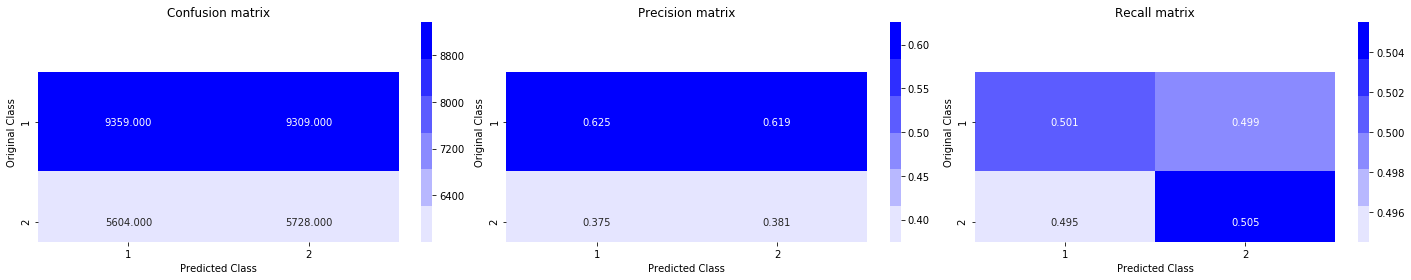

In [61]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data


#creating an array of zeros with two columns for class 0 and class 1
predicted_y = np.zeros((test_len,2))


for i in range(test_len):
    
    
    #Generate two random probability values 
    rand_probs = np.random.rand(1,2)
    
    #Here we are normalizing the vector obtained so that the sum of the values will be equal to 
    #1 and can be treated as probability.
    
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
    
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))




## Take the class label (0 or 1) from probability matrix
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)


The Random Model gave a logloss value of 0.879 which is very high. Now we need our models with logloss less than this value.

**Confusion Matrix:**  

- The original class 1 has (9359+9309) points out of which 9359 are predicted to be class 1 and 9309 predicated to be class 2 i.e 50% each class.  

- The original class 2 has (5604+5728) points out of which 5604 are predicted to be class 1 and 5728 predicted to be class 2 i.e 50% each class.

- class 1 has more points


**Precision Matrix:** the ability of a classification model to identify only the relevant data points.

- Column wise sum will be 1.
- Out of all predicted in class 1 only 62.5% have original label as 1.
- Out of all predicted in class 2 only 38.1% have original label as 2
- SO the diagonal values actually refer the precision values of class 1 and 2 respectively.


**Recall Matrix:**  the ability of a model to find all the relevant cases within a dataset. The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives. Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.    

- Row wise sum will be 1.
- Out of original class 1 only 50.1% has been predicted as 1.
- Out of original class 2 only 50.5% has been predicted as 2.
- SO the diagonal values actually refer the recall values of class 1 and 2 respectively.

##### While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

### Trying Linear Models

### Logistic Regression using SGD classifier

For values of alpha =  1e-05 The log loss is: 0.4404865431870565
For values of alpha =  0.0001 The log loss is: 0.4481868635198612
For values of alpha =  0.001 The log loss is: 0.4545892128404511
For values of alpha =  0.01 The log loss is: 0.42593506630719385
For values of alpha =  0.1 The log loss is: 0.4407376201210324
For values of alpha =  1 The log loss is: 0.48718182988168535
For values of alpha =  10 The log loss is: 0.5450037207751464


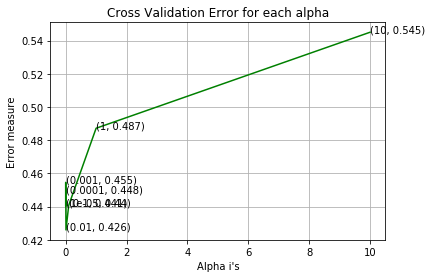

For values of best alpha =  0.01 The train log loss is: 0.41867894763164926
For values of best alpha =  0.01 The test log loss is: 0.42593506630719385
Total number of data points : 30000


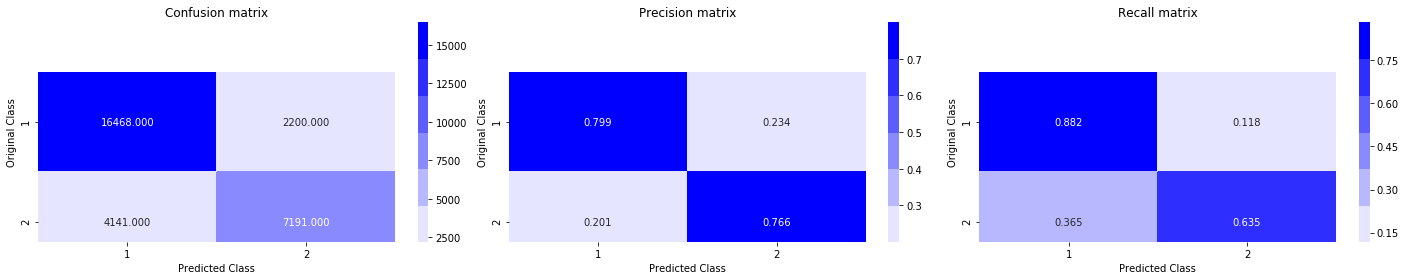

In [66]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
log_error_train=[]

for i in alpha:
    
    #the loss parameter should br log for logistic regression
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    predict_y_train = sig_clf.predict_proba(X_train)
    
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_train.append(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))

    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


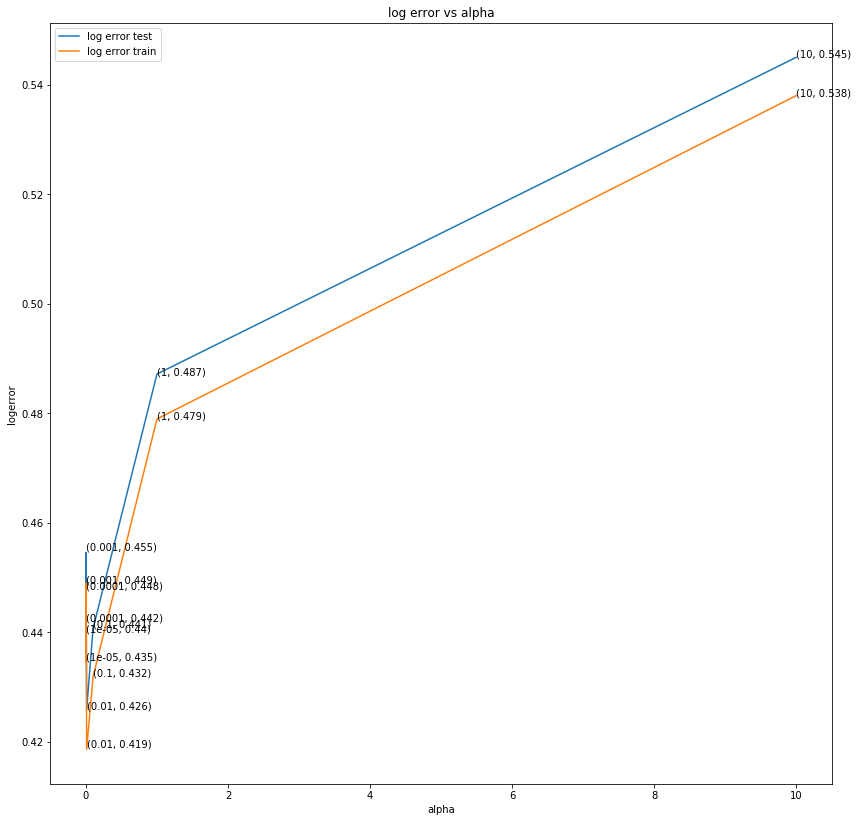

In [69]:
fig = plt.figure(figsize=(14,14))

for xy in zip(alpha, np.round(log_error_array,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
for xy in zip(alpha, np.round(log_error_train,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  
    
ax = plt.subplot(111)
ax.plot(alpha, log_error_array, label='log error test')
ax.plot(alpha, log_error_train, label='log error train')
plt.title('log error vs alpha')
plt.xlabel('alpha')
plt.ylabel('logerror')
ax.legend()
plt.show()

- Low train error but high test error means overfit 
- High train erro and hence high test erro means underfit
- Ideally we should have low train error i.e low logloss and not so high text error . So both the curves should be close to eachother as much as possible with train logloss being Low

### Linear SVM using SGD classifier

For values of alpha =  1e-05 The log loss is: 0.42681508370396437
For values of alpha =  0.0001 The log loss is: 0.44459954081603803
For values of alpha =  0.001 The log loss is: 0.45080046733032014
For values of alpha =  0.01 The log loss is: 0.5274333093985579
For values of alpha =  0.1 The log loss is: 0.5090872109508097
For values of alpha =  1 The log loss is: 0.581708811800059
For values of alpha =  10 The log loss is: 0.6025989497404812


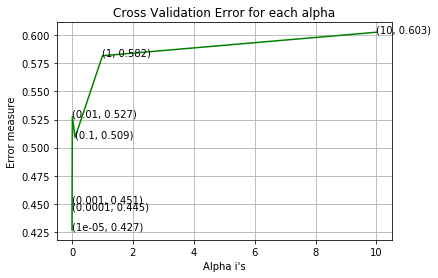

For values of best alpha =  1e-05 The train log loss is: 0.41906378344115675
For values of best alpha =  1e-05 The test log loss is: 0.42681508370396437
Total number of data points : 30000


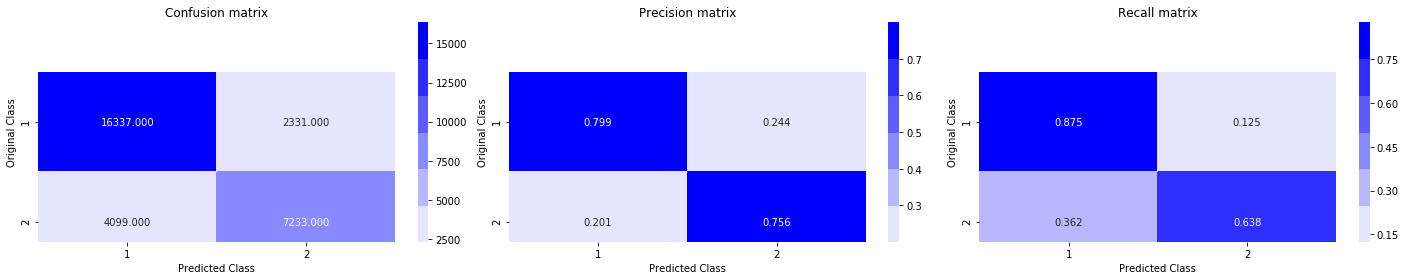

In [71]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
log_error_train=[]
for i in alpha:
    
    #the loss parameter should be hinge and penalty l1 is applied.
    
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', max_iter=10000,random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    predict_y_train = sig_clf.predict_proba(X_train)

    log_error_train.append(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


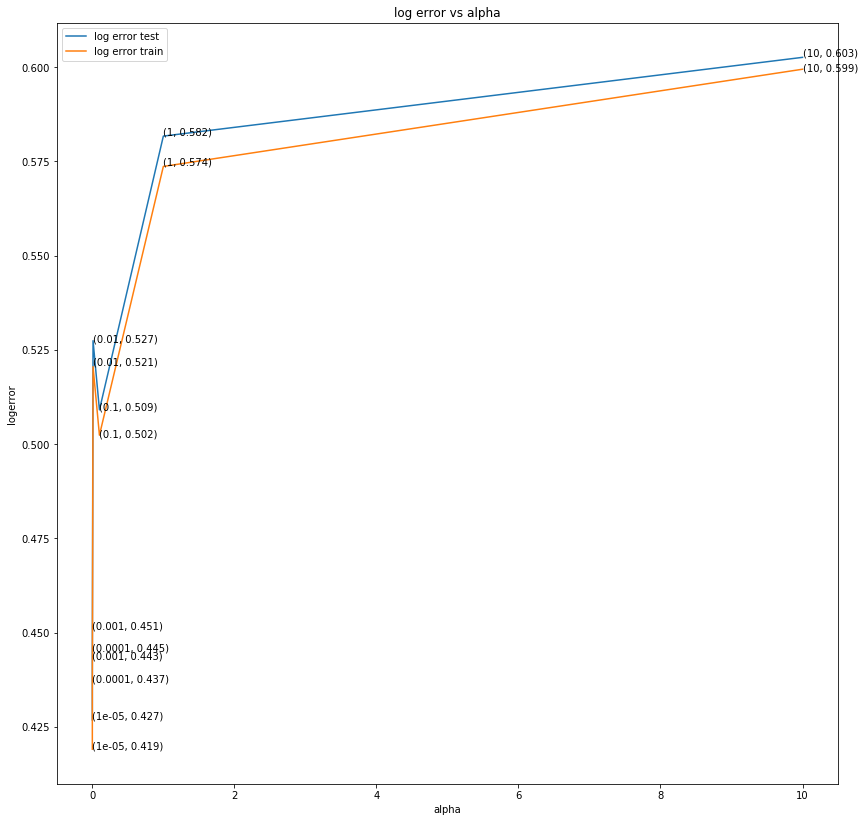

In [72]:
fig = plt.figure(figsize=(14,14))

for xy in zip(alpha, np.round(log_error_array,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
for xy in zip(alpha, np.round(log_error_train,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  
    
ax = plt.subplot(111)
ax.plot(alpha, log_error_array, label='log error test')
ax.plot(alpha, log_error_train, label='log error train')
plt.title('log error vs alpha')
plt.xlabel('alpha')
plt.ylabel('logerror')
ax.legend()
plt.show()

#### Using GridSearch CV for checking the tuned parameter.

**'neg_log_loss'** as a scoring scheme as in 'GridSearchCV", the score is negative -- the bigger the score, the better the performance.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.1,1, 10, 100]}

grid = GridSearchCV(SVC(),param_grid,scoring="neg_log_loss",cv=3,refit=True)
grid.fit(X_train, y_train)

### Trying Complex non linear models

### XGBoost

In [74]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4


# It is a Data Matrix. 
# DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

#  It used to specify validations set to watch the performance. 

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)

predict_y = bst.predict(d_test)



[0]	train-logloss:0.68482	valid-logloss:0.68496
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61581	valid-logloss:0.61700
[20]	train-logloss:0.56473	valid-logloss:0.56682
[30]	train-logloss:0.52628	valid-logloss:0.52905
[40]	train-logloss:0.49722	valid-logloss:0.50056
[50]	train-logloss:0.47429	valid-logloss:0.47813
[60]	train-logloss:0.45613	valid-logloss:0.46051
[70]	train-logloss:0.44132	valid-logloss:0.44618
[80]	train-logloss:0.42926	valid-logloss:0.43451
[90]	train-logloss:0.41941	valid-logloss:0.42507
[100]	train-logloss:0.41136	valid-logloss:0.41726
[110]	train-logloss:0.40463	valid-logloss:0.41087
[120]	train-logloss:0.39885	valid-logloss:0.40553
[130]	train-logloss:0.39370	valid-logloss:0.40078
[140]	train-logloss:0.38917	valid-logloss:0.39658
[150]	train-logloss:0.38527	valid-logloss:0.39291
[160]	train-logloss:0.38188	valid-logloss:0.38982
[170]	trai

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [75]:
predict_y_train = bst.predict(d_train)

In [76]:
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))

The test log loss is: 0.3575949478730113
The train log loss is: 0.3435928271164319


with a watchlist containing [(dtest,'eval'), (dtrain,'train')] and a parameter containing ('eval_metric': 'logloss'), the evals_result returns  

{'train': {'logloss': ['0.48253', '0.35953']},  
 'eval': {'logloss': ['0.480385', '0.357756']}}  

#### Here log loss is much reduced with the XGBoost Model.So it is better to proceed with XGBoost.So we can try hyper parameter tuning for XGBoost to enhance the model.

Total number of data points : 30000


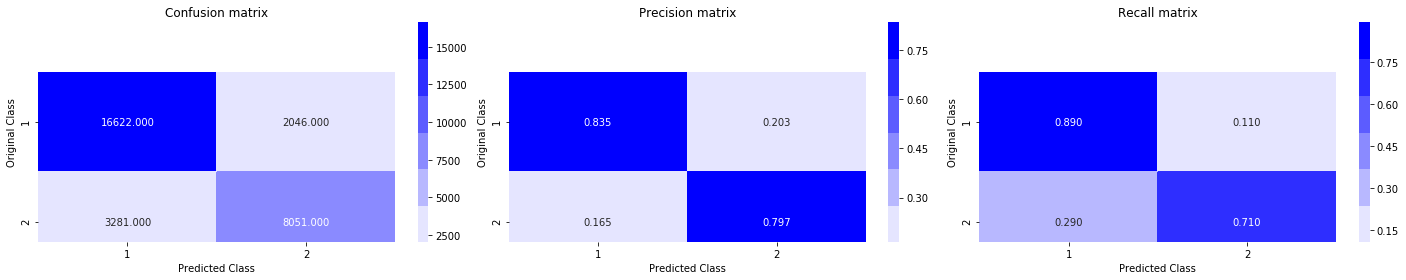

In [77]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Confusion Matrix:**  

- The original class 1 has (36622+2046) points out of which 36622 are predicted to be class 1 and 2046 predicated to be class 2   

- The original class 2 has (3281+8051) points out of which 3281 are predicted to be class 1 and 8051 predicted to be class 2 

- class 1 has more points


**Precision Matrix:** the ability of a classification model to identify only the relevant data points.

- Column wise sum will be 1.
- Out of all predicted in class 1 only 83.5% have original label as 1.
- Out of all predicted in class 2 only 79.7% have original label as 2
- SO the diagonal values actually refer the precision values of class 1 and 2 respectively.


**Recall Matrix:**  the ability of a model to find all the relevant cases within a dataset. The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives. Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.    

- Row wise sum will be 1.
- Out of original class 1 89.0% has been predicted as 1.
- Out of original class 2 71.0% has been predicted as 2.
- SO the diagonal values actually refer the recall values of class 1 and 2 respectively.

**Thus recall and precision values are high and also logloss is low.So better to use XG Boost**

#### Feature Importance

In [90]:
feat_dict = bst.get_score(importance_type='gain')

In [100]:
predictors = list(feat_dict.keys())[0:21]
feature_imp = list(feat_dict.values())[0:21]

Text(0, 0.5, 'Feature Importance Score')

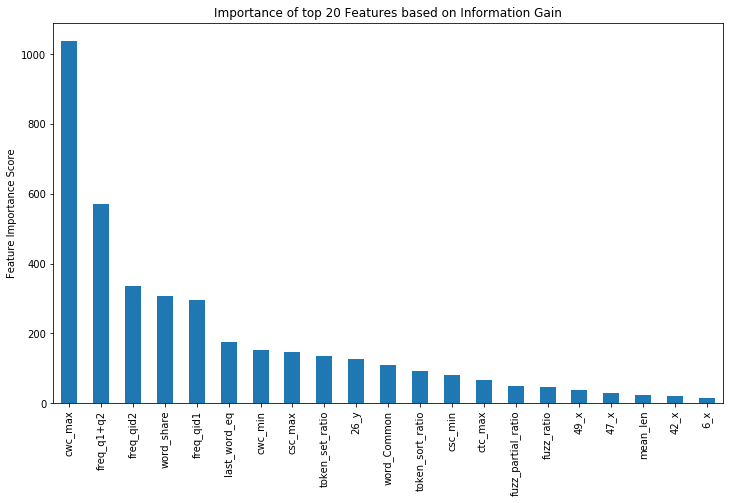

In [102]:
plt.figure(figsize=(12,7))
feat_imp = pd.Series(feature_imp, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of top 20 Features based on Information Gain')
plt.ylabel('Feature Importance Score')

### Saving Model

In [79]:
import pickle

In [80]:
#saving file
filename = 'finalized_xgboost_model.sav'
pickle.dump(bst, open(filename, 'wb'))

In [82]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
predict_y_train = loaded_model.predict(d_train)